In [2]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy import stats as sista
np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Experiment setup
experiment_name = 'colinearity'
data_dir = f'../../Colinearity/{experiment_name}'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False,info_variable_names=['sampling_rate','times'])

In [5]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 15
n_splits = 2
#0: 2 grouped, 1: 2 ungrouped, 2: 4 grouped, 3: 4 ungrouped 
group_dict = {0:[1],1:[2],2:[3]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=3)
clfr.classifier = LogisticRegression()


In [12]:
# If you want to retrain classifiers, run this cell. Otherwise go to next cell.

clfr.confidence_scores = np.empty((exp.nsub,len(wrangl.t),wrangl.n_splits,clfr.num_labels))
for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    
    # Reshaping data into [trials,electrodes,timepoints]
    xdata = np.moveaxis(xdata,[0,1,2],[2,0,1])
    xdata,ydata = wrangl.setup_data(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        
        # remove 4G from training, only train on 2U and 2G
        X_train_all = X_train_all[((y_train == 0) + (y_train == 2))]
        # test on 4G, 2U, and 4U
        y_train = y_train[((y_train == 0) + (y_train == 2))] 
        
        # shuffle labels for chance classification
        y_test_shuffle = np.random.permutation(y_test)
        
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

            # get confidence of classification for each trial bin. >0 means set size 4 is predicted.
            confidence_scores = clfr.classifier.decision_function(X_test)
            for i in set(y_test):
                clfr.confidence_scores[isub,wrangl.itime,wrangl.ifold,i] = np.mean(confidence_scores[y_test==i])

In [13]:
# Set up interp object and load results. Or uncomment interp.save_results if you just reran classification and want to save results.
interp = decode_eeg.Interpreter(clfr, subtitle = f'colinearity_preds')
interp.confidence_scores = clfr.confidence_scores
# interp.save_results(additional_values=['confidence_scores'])
# interp.load_results()

In [14]:
ss2u = np.mean(interp.confidence_scores,2)[:,:,0]
ss4g = np.mean(interp.confidence_scores,2)[:,:,1]
ss4u = np.mean(interp.confidence_scores,2)[:,:,2]

C:\Users\Jarvis\anaconda3\envs\archery\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [72]:
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.mean(a,0)
    sem = sista.sem(a,0)
    upper,lower = mean + sem, mean - sem
    return mean, upper, lower

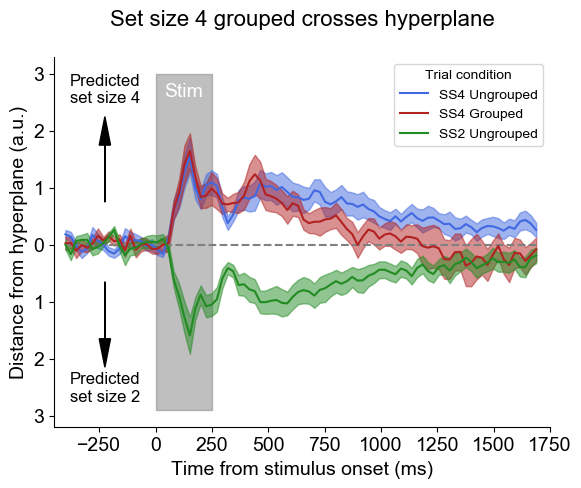

In [79]:
# Plot confidence of classifier, which is proportional to distance from hyperplane.
stim_lower,stim_upper = -2.9,3
stim_time = [0,250]

ax = plt.subplot(111)

ax.fill_between(stim_time,[stim_lower,stim_lower],[stim_upper,stim_upper],color='gray',alpha=.5)
ax.plot(interp.t,np.zeros((len(interp.t))),'--',color='gray')
colors = ['royalblue','firebrick','forestgreen']

med, upper, lower = get_plot_line(ss4u)
ax.plot(interp.t,med,colors[0],label = 'SS4 Ungrouped')
ax.fill_between(interp.t,upper,lower, color=colors[0],alpha=.5)

med, upper, lower = get_plot_line(ss4g)
ax.plot(interp.t,med,colors[1],label = 'SS4 Grouped')
ax.fill_between(interp.t,upper,lower, color=colors[1], alpha=.5)

med, upper, lower = get_plot_line(ss2u)
ax.plot(interp.t,med,colors[2],label = 'SS2 Ungrouped')
ax.fill_between(interp.t,upper,lower, color=colors[2], alpha=.5)

plt.legend(title='Trial condition',loc='upper right')

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.yticks(np.arange(-3,4,1),labels=[3,2,1,0,1,2,3])
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlim(-450,1750)
# plt.ylim([-4,4])

# labelling
plt.title('Set size 4 grouped crosses hyperplane\n',fontsize=16)
plt.xlabel('Time from stimulus onset (ms)', fontsize=14)
plt.ylabel('Distance from hyperplane (a.u.)', fontsize=14)

plt.text(-225,-2.75,'Predicted\nset size 2',fontsize=12,ha='center')
plt.text(-225,2.5,'Predicted\nset size 4',fontsize=12,ha='center')
plt.text(125,2.6,'Stim',fontsize=14,ha='center',c='white')
plt.arrow(-225,.75,0,1, head_width=50, head_length=.5,color='k')
plt.arrow(-225,-.65,0,-1,head_width=50, head_length=.5,color='k')

plt.savefig('colinearity_hyperplane.png',dpi=500)
plt.show()